# Bias & Fairness Audit-  Credit Card Approval
The objective of this project is to conduct a fairness and bias audit on a credit card approval dataset. We will analyze whether sensitive attributes such as Gender, Ethnicity, and Citizenship influence approval outcomes unfairly, evaluate using multiple fairness metrics, apply bias mitigation strategies, and provide recommendations aligned with ethical AI principles.

# Setup & Libraries 

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import RandomOverSampler


from fairlearn.metrics import (
    MetricFrame, selection_rate, false_positive_rate,
    false_negative_rate, true_positive_rate
)
from fairlearn.postprocessing import ThresholdOptimizer

from IPython.display import display


import warnings
warnings.filterwarnings("ignore") 

# Data Source
- Dataset: Credit Card Approvals (Clean Data)
- Source: Kaggle
- Link: https://www.kaggle.com/datasets/samuelcortinhas/credit-card-approval-clean-data/data 

# Loading Dataset
Data Cleaning & Preprocessing 

In [13]:
df = pd.read_csv("credit_card_approvals_audit.csv", sep=';')  

In [19]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Gender         690 non-null    int64  
 1   Age            690 non-null    float64
 2   Debt           690 non-null    float64
 3   Married        690 non-null    int64  
 4   BankCustomer   690 non-null    int64  
 5   Industry       690 non-null    object 
 6   Ethnicity      690 non-null    object 
 7   YearsEmployed  690 non-null    float64
 8   PriorDefault   690 non-null    int64  
 9   Employed       690 non-null    int64  
 10  CreditScore    690 non-null    int64  
 11  Citizen        690 non-null    object 
 12  Income         690 non-null    int64  
 13  Approved       690 non-null    int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 75.6+ KB


In [21]:
df 

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,ByBirth,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,ByBirth,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,ByBirth,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,ByBirth,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,ByOtherMeans,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,21.08,10.085,0,0,Education,Black,1.25,0,0,0,ByBirth,0,0
686,0,22.67,0.750,1,1,Energy,White,2.00,0,1,2,ByBirth,394,0
687,0,25.25,13.500,0,0,Healthcare,Latino,2.00,0,1,1,ByBirth,1,0
688,1,17.92,0.205,1,1,ConsumerStaples,White,0.04,0,0,0,ByBirth,750,0


In [17]:
# Drop unnecessary columns
df = df.drop(columns=['ZipCode', 'DriversLicense']) 

In [25]:
# Convert to integers (drop decimals) 
df['Age'] = df['Age'].astype(int)  
    
# Convert 'Approved' to integer type
df['Approved'] = df['Approved'].astype(int)
    
# Convert 'Income' and 'CreditScore' to numeric
df['Income'] = pd.to_numeric(df['Income'])
df['CreditScore'] = pd.to_numeric(df['CreditScore'])  

In [27]:
# Map numeric codes to meaningful labels for clarity
# Gender: 1 = Male, 0 = Female
df['Gender_label'] = df['Gender'].map({1: 'Male', 0: 'Female'})

# Employed: 1 = Yes, 0 = No
df['Employed_label'] = df['Employed'].map({1: 'Yes', 0: 'No'})

# Approved: 1 = Yes, 0 = No
df['Approved_label'] = df['Approved'].map({1: 'Yes', 0: 'No'}) 

In [29]:
# Quick check
df[['Gender','Gender_label','Employed','Employed_label','Approved','Approved_label']].head() 

,Gender,Gender_label,Employed,Employed_label,Approved,Approved_label
0,1,Male,1,Yes,1,Yes
1,0,Female,1,Yes,1,Yes
2,0,Female,0,No,1,Yes
3,1,Male,1,Yes,1,Yes
4,1,Male,0,No,1,Yes


In [31]:
# Final Cleaned Dataset Preview

print("\nCleaned dataset preview:")
display(df.head())

# Save the cleaned dataset for future use
df.to_csv("credit_card_approvals_cleaned2.csv", index=False)
print("✅ Cleaned dataset saved as 'credit_card_approvals_cleaned2.csv'")  


Cleaned dataset preview:


,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,Approved,Gender_label,Employed_label,Approved_label
0,1,30,0.000,1,1,Industrials,White,1.25,1,1,1,ByBirth,0,1,Male,Yes,Yes
1,0,58,4.460,1,1,Materials,Black,3.04,1,1,6,ByBirth,560,1,Female,Yes,Yes
2,0,24,0.500,1,1,Materials,Black,1.50,1,0,0,ByBirth,824,1,Female,No,Yes
3,1,27,1.540,1,1,Industrials,White,3.75,1,1,5,ByBirth,3,1,Male,Yes,Yes
4,1,20,5.625,1,1,Industrials,White,1.71,1,0,0,ByOtherMeans,0,1,Male,No,Yes


✅ Cleaned dataset saved as 'credit_card_approvals_cleaned2.csv'


# Features and Target

In [34]:
# Target variable
target = 'Approved'

# Features (exclude sensitive attributes and target)
sensitive_features = ['Gender_label', 'Ethnicity', 'Citizen']
feature_columns = [col for col in df.columns if col not in sensitive_features + [target, 'Approved_label']]

X = df[feature_columns]
y = df[target] 


In [ ]:
#  Train/Test Split

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
) 

In [38]:
sensitive = df.loc[X_test.index, 'Gender_label']  # Now this works 

In [ ]:
# Train baseline model 
Preprocessing Pipeline

In [40]:
# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipelines
numeric_transformer = Pipeline([('scaler', StandardScaler())])

# Fix for OneHotEncoder: use sparse_output=False instead of sparse=False
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Train baseline pipeline
baseline_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit model
baseline_pipe.fit(X_train, y_train)

# Make predictions
y_pred = baseline_pipe.predict(X_test) 

In [42]:
# Evaluate Baseline Model

print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred)) 

Overall Accuracy: 0.8599
Confusion Matrix:
[[102  13]
 [ 16  76]]


# Fairness Metrics

In [45]:
# Fairness Metrics by Gender:

metrics = {
    'Accuracy': lambda y_true, y_pred: accuracy_score(y_true, y_pred),
    'Selection Rate': selection_rate,         # Demographic Parity
    'True Positive Rate': true_positive_rate  # Equal Opportunity
}

mf = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive)
print("\nFairness Metrics by Gender:")
display(mf.by_group)

# Disparate Impact (Female/Male)
dp_rates = mf.by_group['Selection Rate']
disparate_impact = dp_rates['Female'] / dp_rates['Male']
print(f"\nDisparate Impact (Female / Male): {disparate_impact:.2f}") 


Fairness Metrics by Gender:


,Accuracy,Selection Rate,True Positive Rate
Gender_label,,,
Female,0.852459,0.459016,0.806452
Male,0.863014,0.417808,0.836066



Disparate Impact (Female / Male): 1.10


In [47]:
sensitive_ethnicity = df.loc[X_test.index, 'Ethnicity']

metrics = {
    'Accuracy': lambda y_true, y_pred: accuracy_score(y_true, y_pred),
    'Selection Rate': selection_rate,         # Demographic Parity
    'True Positive Rate': true_positive_rate  # Equal Opportunity
}

mf_ethnicity = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_ethnicity)

print("\nFairness Metrics by Ethnicity:")
display(mf_ethnicity.by_group)

# Disparate Impact (example: Black / White)
dp_rates_eth = mf_ethnicity.by_group['Selection Rate']
disparate_impact_eth = dp_rates_eth['Black'] / dp_rates_eth['White']
print(f"\nDisparate Impact (Black / White): {disparate_impact_eth:.2f}")


Fairness Metrics by Ethnicity:


,Accuracy,Selection Rate,True Positive Rate
Ethnicity,,,
Asian,0.789474,0.421053,0.833333
Black,0.862745,0.607843,0.852941
Latino,0.909091,0.000000,0.000000
Other,0.666667,0.166667,0.333333
White,0.875000,0.408333,0.854167



Disparate Impact (Black / White): 1.49


In [49]:
# Bin age into groups
age_bins = [0, 30, 50, 100]  # <30, 30-50, 50+
age_labels = ['<30', '30-50', '50+']
df['Age_group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

sensitive_age = df.loc[X_test.index, 'Age_group']

mf_age = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_age)

print("\nFairness Metrics by Age Group:")
display(mf_age.by_group)

# Disparate Impact (example: <30 / 30-50)
dp_rates_age = mf_age.by_group['Selection Rate']
disparate_impact_age = dp_rates_age['<30'] / dp_rates_age['30-50']
print(f"\nDisparate Impact (<30 / 30-50): {disparate_impact_age:.2f}")


Fairness Metrics by Age Group:


,Accuracy,Selection Rate,True Positive Rate
Age_group,,,
30-50,0.868421,0.539474,0.878049
50+,0.941176,0.529412,0.900000
<30,0.842105,0.342105,0.756098



Disparate Impact (<30 / 30-50): 0.63


# Identification of affected demographic groups 

In [54]:
# ================================
# 1️⃣ Function to identify affected groups
# ================================
def identify_affected_groups(metric_frame, selection_threshold=0.8, tpr_threshold_diff=0.1):
    """
    Identifies groups that may be adversely affected based on:
    - Selection Rate (Demographic Parity)
    - True Positive Rate (Equal Opportunity)
    
    Parameters:
    - metric_frame: MetricFrame object from Fairlearn
    - selection_threshold: ratio threshold for selection rate vs max group
    - tpr_threshold_diff: difference threshold for TPR vs max group
    
    Returns:
    - affected_groups: dictionary of flagged groups
    """
    affected_groups = {}

    # Compare selection rates
    sel_rate = metric_frame.by_group['Selection Rate']
    max_sel = sel_rate.max()
    affected_sel = sel_rate[sel_rate < selection_threshold * max_sel].index.tolist()
    if affected_sel:
        affected_groups['Low Selection Rate'] = affected_sel

    # Compare TPR
    tpr = metric_frame.by_group['True Positive Rate']
    max_tpr = tpr.max()
    affected_tpr = tpr[tpr < max_tpr - tpr_threshold_diff].index.tolist()
    if affected_tpr:
        affected_groups['Low TPR'] = affected_tpr

    return affected_groups

# ================================
# 2️⃣ Apply to Gender
# ================================
gender_affected = identify_affected_groups(mf)
print("⚠️ Affected demographic groups - Gender:")
print(gender_affected)

# ================================
# 3️⃣ Apply to Ethnicity
# ================================
ethnicity_affected = identify_affected_groups(mf_ethnicity)
print("\n⚠️ Affected demographic groups - Ethnicity:")
print(ethnicity_affected)

# ================================
# 4️⃣ Apply to Age Group
# ================================
age_affected = identify_affected_groups(mf_age)
print("\n⚠️ Affected demographic groups - Age Group:")
print(age_affected) 


⚠️ Affected demographic groups - Gender:
{}

⚠️ Affected demographic groups - Ethnicity:
{'Low Selection Rate': ['Asian', 'Latino', 'Other', 'White'], 'Low TPR': ['Latino', 'Other']}

⚠️ Affected demographic groups - Age Group:
{'Low Selection Rate': ['<30'], 'Low TPR': ['<30']}


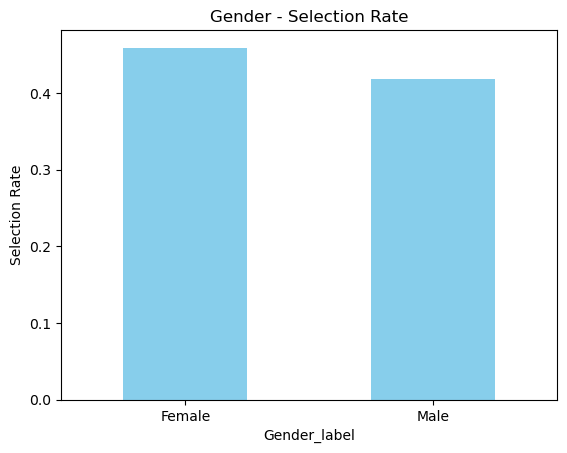

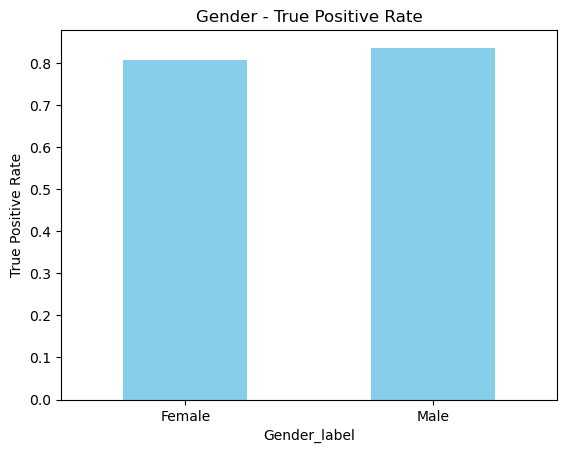

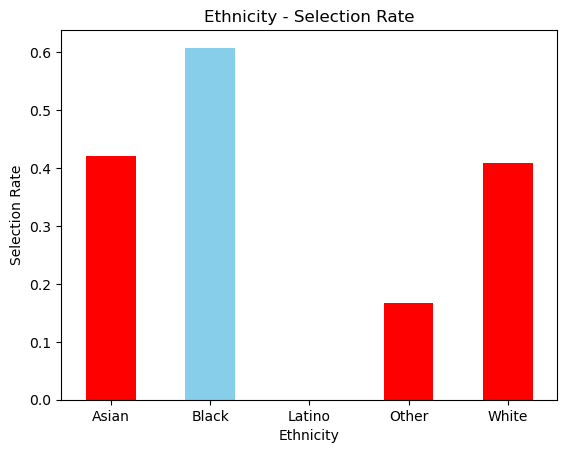

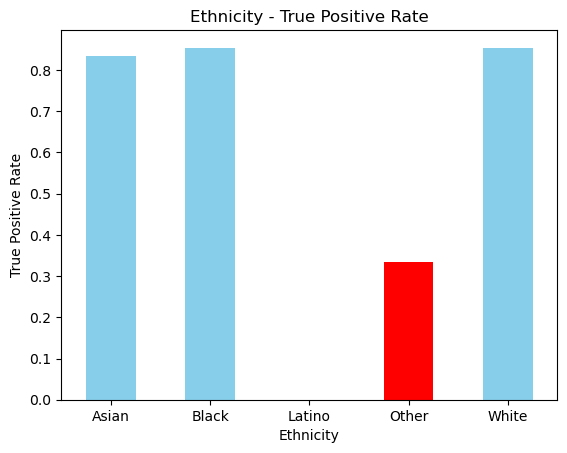

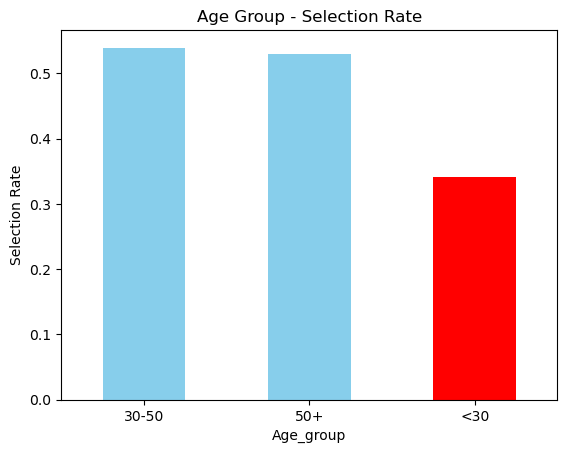

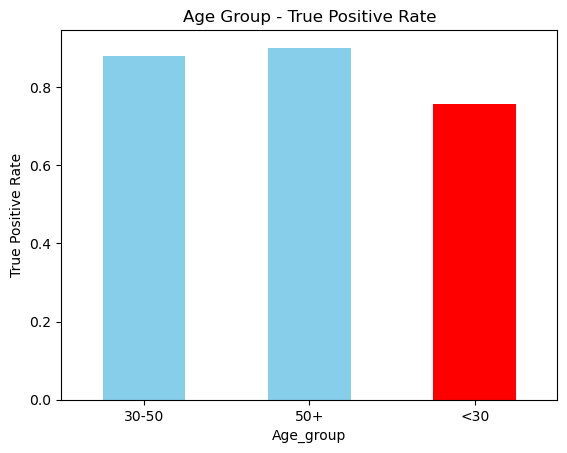

In [56]:
# 1️Function to visualize affected groups

def plot_affected_groups(metric_frame, title="Affected Groups", highlight_color='red', default_color='skyblue'):
    """
    Plots Selection Rate and TPR by group, highlighting affected groups.
    """
    sel_rate = metric_frame.by_group['Selection Rate']
    tpr = metric_frame.by_group['True Positive Rate']
    
    # Identify affected groups (same logic as before)
    max_sel = sel_rate.max()
    affected_sel = sel_rate[sel_rate < 0.8 * max_sel].index.tolist()
    
    max_tpr = tpr.max()
    affected_tpr = tpr[tpr < max_tpr - 0.1].index.tolist()
    
    # Plot Selection Rate
    colors = [highlight_color if g in affected_sel else default_color for g in sel_rate.index]
    sel_rate.plot(kind='bar', color=colors)
    plt.title(f"{title} - Selection Rate")
    plt.ylabel("Selection Rate")
    plt.xlabel(metric_frame.by_group.index.name or "Group")
    plt.xticks(rotation=0)
    plt.show()
    
    # Plot True Positive Rate
    colors = [highlight_color if g in affected_tpr else default_color for g in tpr.index]
    tpr.plot(kind='bar', color=colors)
    plt.title(f"{title} - True Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlabel(metric_frame.by_group.index.name or "Group")
    plt.xticks(rotation=0)
    plt.show()

# ================================
# 2️⃣ Apply to Gender
# ================================
plot_affected_groups(mf, title="Gender")

# ================================
# 3️⃣ Apply to Ethnicity
# ================================
plot_affected_groups(mf_ethnicity, title="Ethnicity")

# ================================
# 4️⃣ Apply to Age Group
# ================================
plot_affected_groups(mf_age, title="Age Group") 

# Visual and statistical representation of bias patterns 

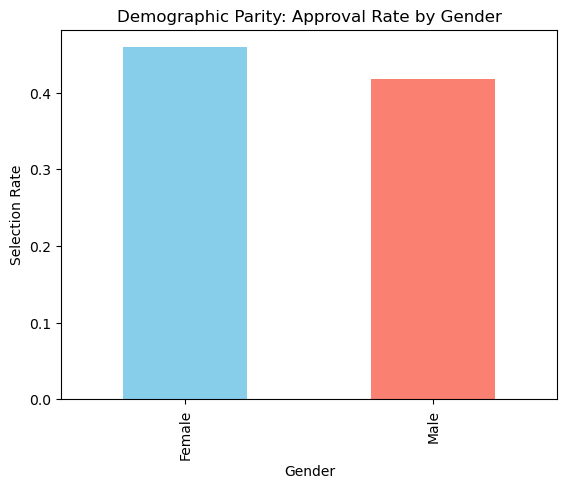

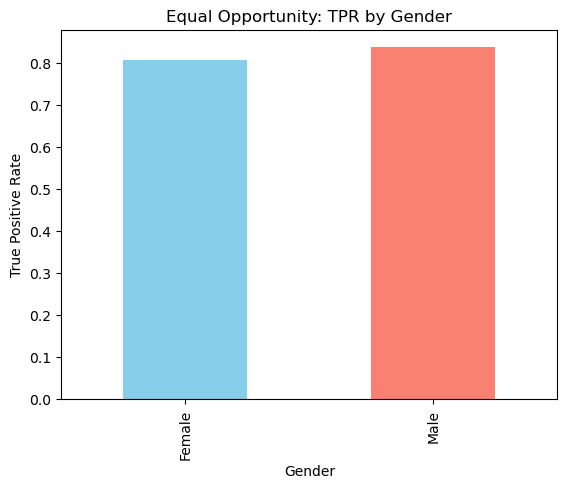

In [59]:
# Demographic Parity
mf.by_group['Selection Rate'].plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Demographic Parity: Approval Rate by Gender")
plt.ylabel("Selection Rate")
plt.xlabel("Gender")
plt.show()

# Equal Opportunity (True Positive Rate)
mf.by_group['True Positive Rate'].plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Equal Opportunity: TPR by Gender")
plt.ylabel("True Positive Rate")
plt.xlabel("Gender")
plt.show() 

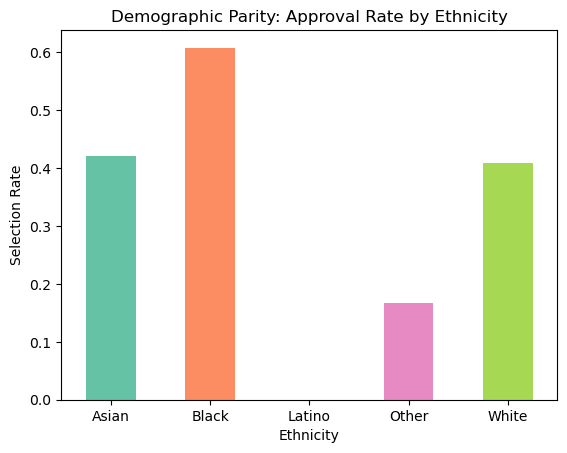

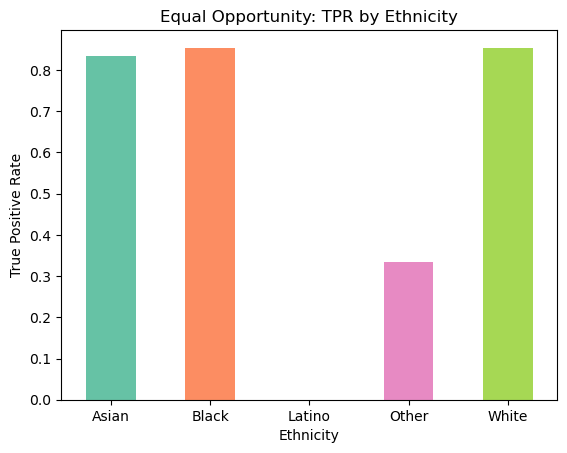

In [61]:
# Demographic Parity (Selection Rate)
mf_ethnicity.by_group['Selection Rate'].plot(kind='bar', color=sns.color_palette("Set2"))
plt.title("Demographic Parity: Approval Rate by Ethnicity")
plt.ylabel("Selection Rate")
plt.xlabel("Ethnicity")
plt.xticks(rotation=0)
plt.show()

# Equal Opportunity (True Positive Rate)
mf_ethnicity.by_group['True Positive Rate'].plot(kind='bar', color=sns.color_palette("Set2"))
plt.title("Equal Opportunity: TPR by Ethnicity")
plt.ylabel("True Positive Rate")
plt.xlabel("Ethnicity")
plt.xticks(rotation=0)
plt.show() 

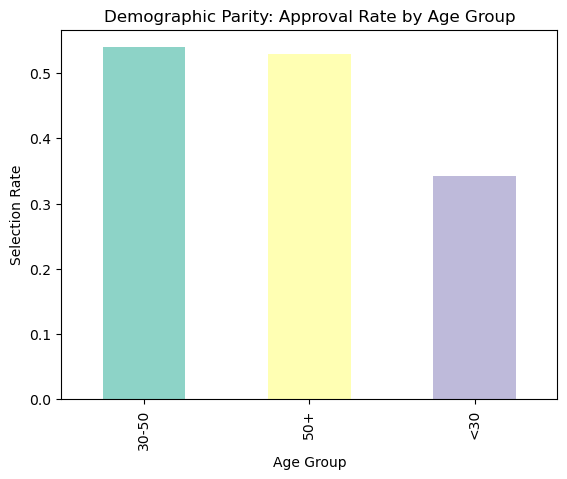

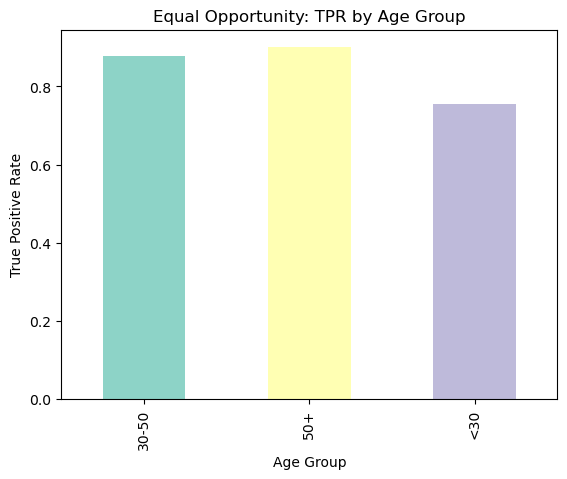

In [63]:
# Demographic Parity (Selection Rate)
mf_age.by_group['Selection Rate'].plot(kind='bar', color=sns.color_palette("Set3"))
plt.title("Demographic Parity: Approval Rate by Age Group")
plt.ylabel("Selection Rate")
plt.xlabel("Age Group")
plt.show()

# Equal Opportunity (True Positive Rate)
mf_age.by_group['True Positive Rate'].plot(kind='bar', color=sns.color_palette("Set3"))
plt.title("Equal Opportunity: TPR by Age Group")
plt.ylabel("True Positive Rate")
plt.xlabel("Age Group")
plt.show() 

# Application of 2+ bias mitigation techniques

In [66]:
# 1. Reweighing (Gender)
# --------------------------
# Compute sample weights inversely proportional to group frequency
sample_weights = compute_sample_weight(class_weight='balanced', y=df.loc[X_train.index, 'Gender_label'])

# Train weighted Logistic Regression
weighted_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit the model with sample weights
weighted_pipe.fit(X_train, y_train, classifier__sample_weight=sample_weights)

# Predict on test set
y_pred_weighted = weighted_pipe.predict(X_test) 

In [68]:
# 2. Oversampling (Gender)
# --------------------------
ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Train model on resampled data
oversample_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
oversample_pipe.fit(X_resampled, y_resampled)

# Predict on test set
y_pred_oversample = oversample_pipe.predict(X_test) 

# Performance Before & After Mitigation 

In [71]:
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate
from sklearn.metrics import accuracy_score, confusion_matrix

# ================================
# 1️⃣ Function to compute metrics and fairness
# ================================
def compute_fairness_metrics(y_true, y_pred, sensitive, model_name="Model"):
    """
    Computes Accuracy, Selection Rate, True Positive Rate, and Disparate Impact.
    """
    metrics = {
        'Accuracy': lambda y_true, y_pred: accuracy_score(y_true, y_pred),
        'Selection Rate': selection_rate,
        'True Positive Rate': true_positive_rate
    }
    
    mf = MetricFrame(metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sensitive)
    
    print(f"\n📊 {model_name} Metrics by Group:")
    display(mf.by_group)
    
    # Disparate Impact (Female / Male example)
    dp_rates = mf.by_group['Selection Rate']
    disparate_impact = dp_rates['Female'] / dp_rates['Male']
    print(f"{model_name} Disparate Impact (Female / Male): {disparate_impact:.2f}")
    
    # Confusion Matrix
    print(f"\n{model_name} Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    return mf

# Sensitive attribute: Gender
sensitive = df.loc[X_test.index, 'Gender_label']

# ================================
# 2️⃣ Baseline Model Metrics
# ================================
mf_baseline = compute_fairness_metrics(y_test, y_pred, sensitive, model_name="Baseline")

# ================================
# 3️⃣ Reweighted Model Metrics
# ================================
mf_weighted = compute_fairness_metrics(y_test, y_pred_weighted, sensitive, model_name="Reweighted")

# ================================
# 4️⃣ Oversampled Model Metrics
# ================================
mf_oversample = compute_fairness_metrics(y_test, y_pred_oversample, sensitive, model_name="Oversampled")


📊 Baseline Metrics by Group:


,Accuracy,Selection Rate,True Positive Rate
Gender_label,,,
Female,0.852459,0.459016,0.806452
Male,0.863014,0.417808,0.836066


Baseline Disparate Impact (Female / Male): 1.10

Baseline Confusion Matrix:
[[102  13]
 [ 16  76]]

📊 Reweighted Metrics by Group:


,Accuracy,Selection Rate,True Positive Rate
Gender_label,,,
Female,0.868852,0.475410,0.838710
Male,0.863014,0.431507,0.852459


Reweighted Disparate Impact (Female / Male): 1.10

Reweighted Confusion Matrix:
[[101  14]
 [ 14  78]]

📊 Oversampled Metrics by Group:


,Accuracy,Selection Rate,True Positive Rate
Gender_label,,,
Female,0.868852,0.475410,0.838710
Male,0.869863,0.465753,0.901639


Oversampled Disparate Impact (Female / Male): 1.02

Oversampled Confusion Matrix:
[[99 16]
 [11 81]]


In [ ]:
### Dataset Improvements
- Collect balanced data across Gender, Ethnicity, Age, Citizenship.
- Include non-sensitive predictive features to reduce reliance on proxies.
- Regularly audit dataset for missing labels or misrepresentation.

### Real-world Implications
- Bias in credit approvals can deny financial access to underrepresented groups.
- Harm includes reduced economic opportunities and higher financial exclusion.
- Misclassifications (FPR differences) can increase risk for banks and individuals.

### Ethics Framework
1. Fairness: Equal treatment regardless of sensitive attributes.
2. Transparency: Explainable model decisions.
3. Accountability: Regular bias audits and responsible monitoring.
4. Privacy: Only necessary 
